# Convolutional Neural Network - Image Recognition
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
The previous notebook we implemented a simple *Convolutional Neural Network* with $TensorFlow$ which has a classification accuracy of about 99%. We will now do a similar thing for a different task, **Image Classification** in the CIFAR-10 data-set, also using the Saver included in $TensorFlow$ to avoid losing the NN once the learning has ended. We will also use **PrettyTensor** for faster implementation.

## Flowchart
The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. First the network has a pre-processing layer which distorts the input images so as to artificially inflate the training-set. Then the network has two convolutional layers, two fully-connected layers and finally a softmax classification layer. The weights and outputs of the convolutional layers are shown in more detail in the larger plots near the end of this notebook.

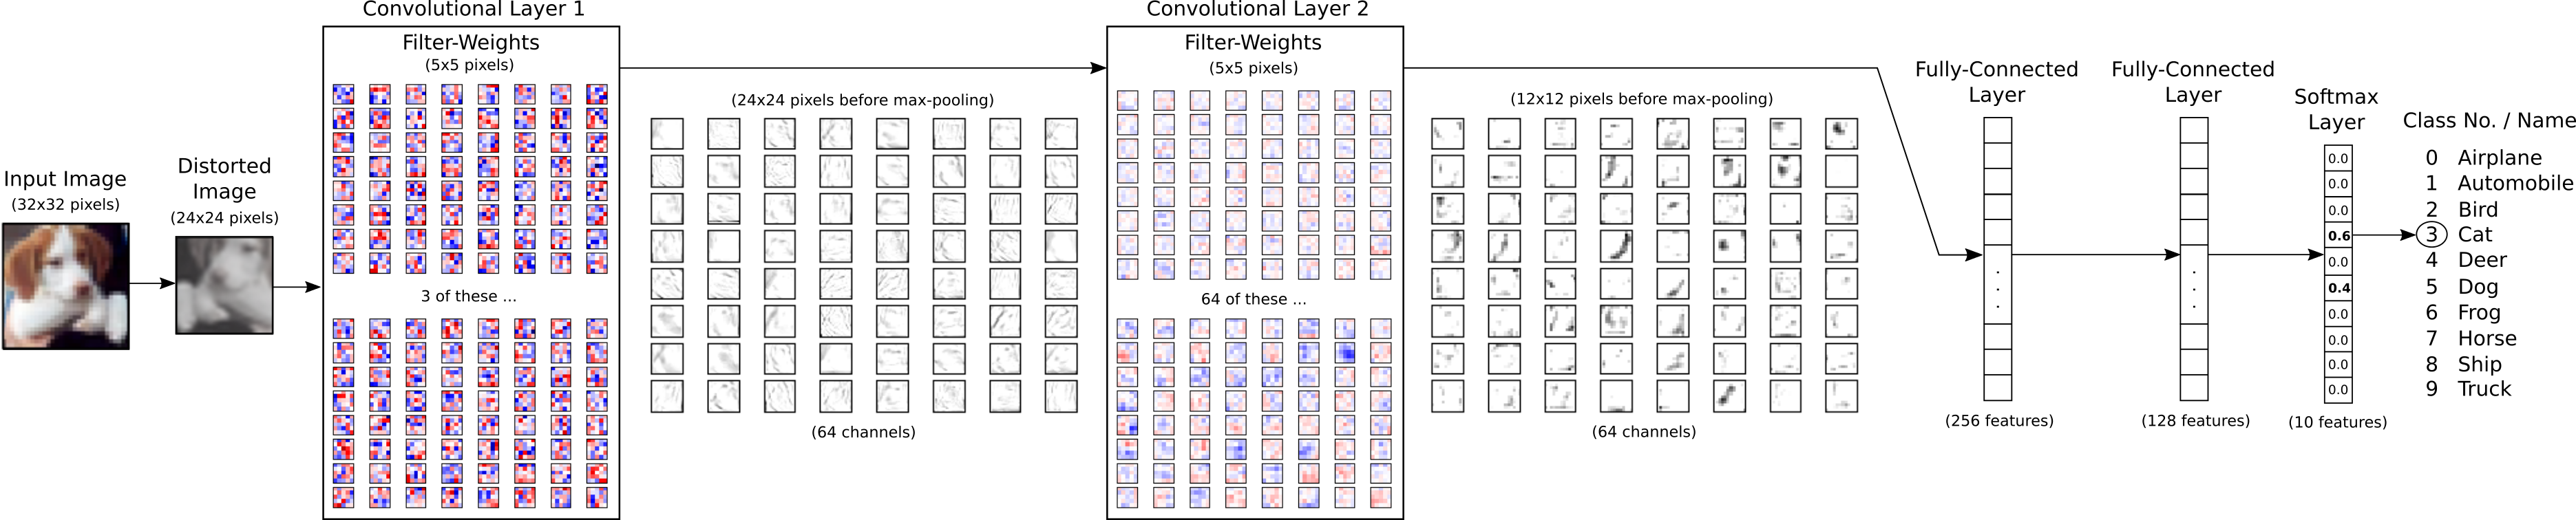

In [1]:
from IPython.display import Image
Image('images/03_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random
import os

from util import Util as u

# We use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

tf.__version__

'0.9.0'

## Data Load

In [3]:
import cifar10
# Set the path for storing the data-set on your computer.
cifar10.data_path = "data/CIFAR-10/"
# The CIFAR-10 data-set is about 163 MB and will be downloaded automatically if it is not located in the given path.
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


### Loading the class-names

In [4]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Loading the training-set
This returns the images, the class-numbers as integers, and the class-numbers as One-Hot encoded arrays called labels.

In [5]:
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5


### Loading the test set

In [6]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


The CIFAR-10 data-set has now been loaded and consists of 60000 images and associated labels. The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [7]:
print("Size of")
print("- Training-set:\t\t{}".format(len(images_train)))
print("- Test-set:\t\t{}".format(len(images_test)))

Size of
- Training-set:		50000
- Test-set:		10000


### Data Dimensions
The data dimensions are used in several places in the source-code below. They have already been defined in the cifar10 module, so we just need to import them.

In [8]:
from cifar10 import img_size, num_channels, num_classes

The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels for computational reasons.

In [9]:
img_size_cropped = 24

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True): 
    u.plot_images_2(self=u, images=images, cls_true=cls_true, class_names=class_names, cls_pred=cls_pred, smooth=smooth)

### Some plotted images from the data set

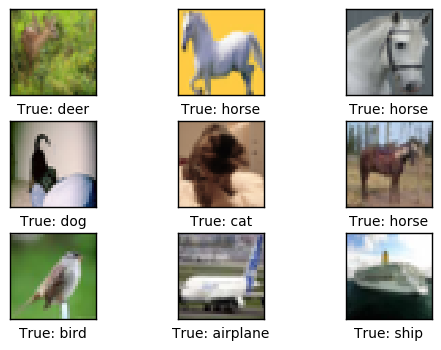

In [11]:
offset = random.randint(0,1000)
# Get the first images from the test-set.
images = images_test[offset:offset+9]

# Get the true classes for those images.
cls_true = cls_test[offset:offset+9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=False)

The pixelated images above (nearest interpolation) are basically what the neural network will get as input. The images might be a bit easier for the human eye to recognize if we smoothen the pixels.

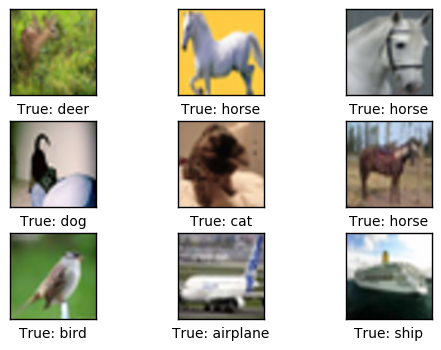

In [12]:
plot_images(images=images, cls_true=cls_true, smooth=True)

## TensorFlow Graph
The structure of the $TensorFlow$ graph is basically the same as the previous notebook, consisting of the following parts:
- Placeholder variables used for inputting data to the graph.
- Variables that are going to be optimized so as to make the convolutional network perform better.
- The mathematical formulas for the convolutional network.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables.

In addition, the $TensorFlow$ graph may also contain various debugging statements e.g. for logging data to be displayed using *TensorBoard*, that we are not going to use here.

### Placeholder variables
Placeholder variables serve as the input to the $TensorFlow$ computational graph that we may change each time we execute the graph. We call this *feeding* the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the $TensorFlow$ graph. This is a so-called *tensor*, which just means that it is a multi-dimensional array. The data-type is set to float32 and the shape is set to [None, img_size, img_size, num_channels], where None means that the tensor may hold an arbitrary number of images with each image being *img_size* pixels high and *img_size* pixels wide and with *num_channels* colour channels.

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length *num_classes* which is 10 in this case.

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using *argmax*. Note that this is a $TensorFlow$ operator so nothing is calculated at this point.

In [15]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Helper-function for creating Pre-Processing
The following helper-functions create the part of the $TensorFlow$ computational graph that pre-processes the input images. Nothing is actually calculated at this point (everything is done using tf), the function merely adds nodes to the computational graph for $TensorFlow$.

The pre-processing is different for training and testing of the neural network:
- For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.
- For testing, the input images are cropped around the centre and nothing else is adjusted.

In [16]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [17]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for $TensorFlow$, so we may execute it later.

In [18]:
distorted_images = pre_process(images=x, training=True)

### Helper-function for creating Main Processing
The following helper-function creates the main part of the convolutional neural network. It uses **PrettyTensor** since it's easier and faster (basically pipe every layer of the network using the PrettyTensor wrapper).

In [19]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(class_count=num_classes, labels=y_true)

    return y_pred, loss

### Helper-function for creating Neural Network
The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the $TensorFlow$ graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [20]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Create Neural Network for Training Phase
First create a $TensorFlow$ variable that keeps track of the number of optimization iterations performed so far. In the previous notebook this was a Python variable, but in this one we want to save this variable with all the other $TensorFlow$ variables in the checkpoints.
Note that *trainable=**False*** which means that $TensorFlow$ will not try to optimize this variable.

In [21]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

Then we create the neural network to be used for training. The create_network() function returns both y_pred and loss, but we only need the loss-function during training.

In [22]:
_, loss = create_network(training=True)

Lastly we create the optimizer which will minimize the loss-function, **Adam Optimizer** again. We also pass the *global_step* variable to the optimizer so it will be increased by one after each iteration.

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)